In [1]:
import torch
# from vit_pytorch import ViT
import torch.nn as nn
from model import MyViT
from torch.utils.data import DataLoader, random_split, Dataset

In [2]:
# Set the seed for PyTorch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [3]:
torch.cuda.is_available()

True

In [4]:
import torch
# from vit_pytorch import ViT

vit_model = MyViT(
    image_size = 28,
    patch_size = 4,
    num_classes = 1000,
    dim = 1028,
    depth = 6,
    heads = 6,
    mlp_dim = 1028 * 3,
    dropout = 0,
    # dropout = 0.1,
    emb_dropout = 0,
    # emb_dropout = 0.1,
    channels = 1
)

img = torch.randn(1, 1, 28, 28)

# BIG
# preds = v(img) # (1, 1000)
# import torch
# # from vit_pytorch import ViT

# vit_model = MyViT(
#     image_size = 28,
#     patch_size = 7,
#     num_classes = 1000,
#     dim = 2056,
#     depth = 4,
#     heads = 6,
#     mlp_dim = 2056 * 3,
#     dropout = 0,
#     # dropout = 0.1,
#     emb_dropout = 0,
#     # emb_dropout = 0.1,
#     channels = 1
# )

# img = torch.randn(1, 1, 28, 28)

# # preds = v(img) # (1, 1000)

16


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

total_params = count_parameters(vit_model)
print(f'Total number of parameters: {total_params}')


Total number of parameters: 48694324


In [7]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # Download and load the test data
# testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [8]:
import torch.utils
import torch.utils.data


train_size = 128
train_dataset, test_dataset = random_split(trainset, [train_size, len(trainset) - train_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [9]:
sample_images = next(iter(trainloader))[0]
test_samples  = next(iter(test_loader))[0]

In [10]:
import matplotlib.pyplot as plt
import torch

def print_images(images):
    """
    Prints a batch of images with shape (64, 1, 28, 28).

    Parameters:
    images (torch.Tensor): A tensor of shape (64, 1, 28, 28) containing the images to be printed.
    """
    # Ensure the input is a 4D tensor
    assert images.ndim == 4, "Input tensor must be 4-dimensional"
    assert images.shape[1] == 1, "Input tensor must have a single channel"
    
    # Get the number of images in the batch
    batch_size = images.shape[0]
    
    # Define the number of rows and columns for the plot grid
    n_cols = 8
    n_rows = (batch_size + n_cols - 1) // n_cols
    
    # Create a figure to hold the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 1.5))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i in range(batch_size):
        # Get the image and remove the channel dimension
        img = images[i, 0, :, :].numpy()
        
        # Plot the image
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    
    # Remove any remaining empty subplots
    for i in range(batch_size, len(axes)):
        axes[i].axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [11]:
# print_images(sample_images)
# with torch.no_grad():
#     print_images(output)

In [15]:
checkpoint_path = './noise/epoch_270000_model_0.00002252.pth'
import os
if not os.path.isfile(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint file '{checkpoint_path}' not found")

In [ ]:
vit_model.load_state_dict(torch.load(checkpoint_path))
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vit_model.to(device)


In [21]:
import torch.optim as optim
import torch
from tqdm import tqdm
import time

# Check if GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Define loss function and optimizer
criterion = nn.MSELoss()
# optimizer = optim.Adam(vit_model.parameters(), lr=0.001)
# milestones = [3000, 6000, 8000, 1000, 12000, 14000, 17000]

optimizer = optim.Adam(vit_model.parameters(), lr=0.0000011)
# optimizer = optim.Adam(vit_model.parameters(), lr=0.00000015)

# Define the learning rate scheduler
milestones = [150000]
milestones = [1000, 2000, 3000, 20000, 14000, 17000]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.6)

# Move the model to the GPU
vit_model.to(device)

num_epochs = 1_600_000

# Parameters for Gaussian noise
mean = 0
std_dev = 0.5  # Standard deviation (adjust as needed)



# Training loop
def train_model(model, optimizer, scheduler, dataloader, target_loss=1e-8):
    model.train()
    with tqdm(total=num_epochs, desc="Processing") as pbar:
        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, _ in dataloader:
                # Move the images to the GPU
                images = images.to(device)
                optimizer.zero_grad()
                # Add Gaussian noise
                noises = torch.normal(mean, std_dev, size=images.shape).to(device)
                noisy_images = images + noises
                outputs = model(noisy_images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            avg_loss = running_loss / len(dataloader)
            pbar.set_postfix({'Loss:': f'{avg_loss}'})
            pbar.update(1)

            # Step the scheduler
            # scheduler.step()
            # if epoch % 400 == 0 and epoch != 0:
            #     time.sleep(90)

            if epoch % 15000 == 0 and epoch != 0:
                torch.save(model.state_dict(), f'./noise/epoch_{epoch}_model_{avg_loss:.8f}.pth')

            # Save intermediate models
            if avg_loss <= target_loss:
                torch.save(model.state_dict(), f'./noise/model_{avg_loss:.8f}.pth')
                break

# Train the model
train_model(vit_model, optimizer, scheduler, train_loader)


Processing:   3%|▎         | 45047/1600000 [56:26<32:33:39, 13.27it/s, Loss:=7.012597779976204e-05] 

In [37]:
def lines_herizontal_noise(img, number_of_lines=5, line_width=2, noise_value=None):
    h, w = img.shape[-2:]
    white_space_size = 1
    square_size = number_of_lines * (2 + white_space_size) # 1 is the space between lines
    start_pos   = (h - square_size) // 2
    end_pos = start_pos + square_size

    noise = noise_value if noise_value else 2 * (torch.rand((line_width, square_size)) - 1)

    img_noisy = img.clone()
    for i in range(number_of_lines):
        img_noisy[:,:,start_pos + (i * (line_width + white_space_size)): start_pos + (i * (line_width + white_space_size)) + line_width, start_pos: end_pos] = noise

    return img_noisy

In [89]:
def right_side_noise(img, noise_value=None):
    h, w = img.shape[-2:]
    noise = 2 * (torch.rand((h, w // 4)) - 1)


    img_noisy = img.clone()
    img_noisy[:,:,:, ((w + 1) // 4) * 3:] = noise_value if noise_value else noise

    return img_noisy

In [86]:
def bottom_noise(img, noise_value=None):
    h, w = img.shape[-2:]
    noise = 2 * (torch.rand((h // 4, w)) - 1)


    img_noisy = img.clone()
    
    img_noisy[:,:, ((h + 1) // 4) * 3:,:] = noise_value if noise_value else noise

    return img_noisy

In [28]:
def square_noise(img, noise_size = 8):
    h, w = img.shape[-2:]

    img_noisy = img.clone()

    start_pos = (h - noise_size) // 2
    end_pos = start_pos + noise_size

    noise = 2 * (torch.rand((noise_size, noise_size)) - 1)
    img_noisy[start_pos: end_pos, start_pos:end_pos] = noise

    return img_noisy

In [63]:
def triangle_noise(img, width=5, noise_value=1):
    h, w = img.shape[-2:]

    img_noisy = img.clone()
    for i in range(h-width):
        img_noisy[:,:,i:i+width,i] = noise_value
    
    return img_noisy

In [61]:
def apply_noise(images, noise_func):
    with torch.no_grad():
        print_images(images.cpu())
        noised_image = noise_func(images.cpu())
        print_images(noised_image)
        outputs = vit_model(noised_image.to(device))
        print_images(outputs.cpu())
        for i in range(20):
            outputs = vit_model(outputs)
        print_images(outputs.cpu())

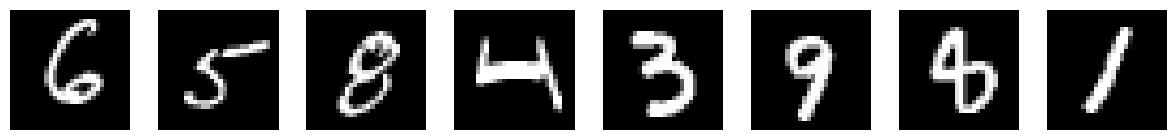

In [78]:
s = sample_images[:8]
print_images(s)
# s = right_side_noise(s, noise_value=1)
# s = right_side_noise(s)
# print_images(s)

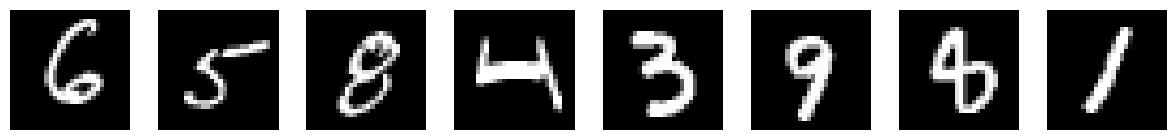

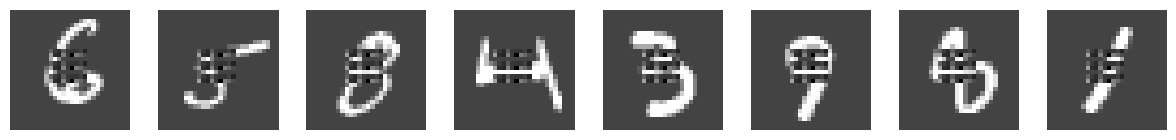

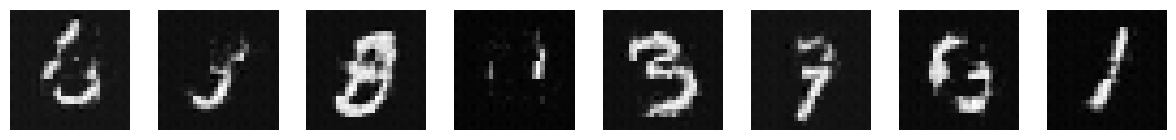

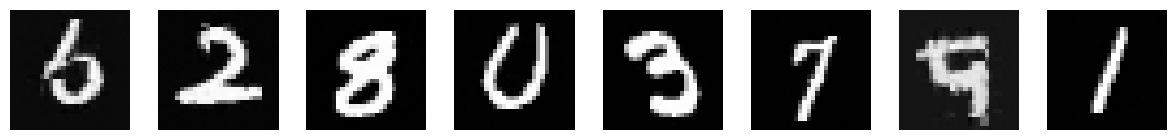

In [93]:
apply_noise(s, lambda x: lines_herizontal_noise(x, number_of_lines=3))
# apply_noise(s, triangle_noise)
# apply_noise(s, lambda x: right_side_noise(x, 1))
# apply_noise(s, lambda x: bottom_noise(x, 1))

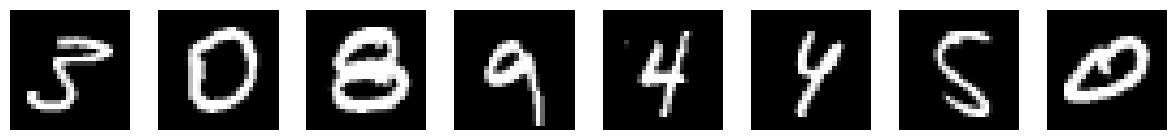

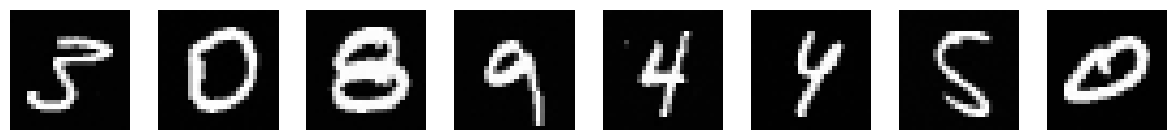

In [23]:
for images, _ in train_loader:
    # Move the images to the GPU
    images = images.to(device)
    # Add Gaussian noise
    # noises = torch.normal(mean, std_dev, size=images.shape).to(device)
    # noisy_images = images + noises
    # outputs = vit_model(images)
    # samples = vit_model((torch.maximum(test_samples[:16,:,:], noise)).to(device)).cpu()

    with torch.no_grad():
        noise = torch.ones((1, 28, 28)) * -1
        noise[:, 10:15, 10:15] = 1
        print_images(images[:8,:,:].cpu())
        outputs = vit_model(images[:8,:,:].to(device)).cpu()
        for i in range(500):
            outputs = vit_model(outputs[:8,:,:].to(device)).cpu()
    print_images(outputs[:8,:,:].cpu())
    
    # loss = criterion(outputs, images)

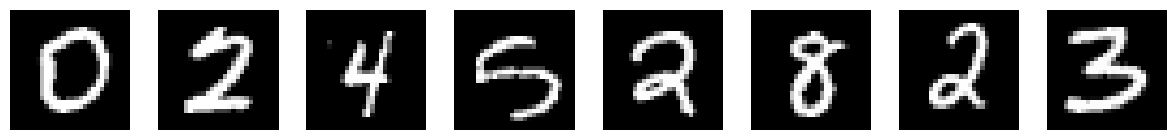

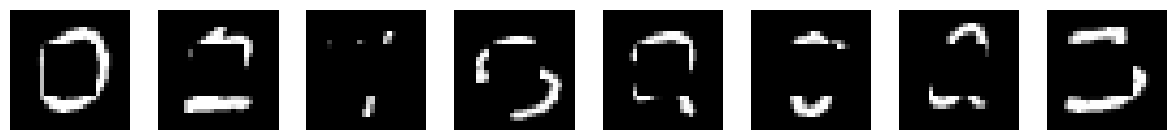

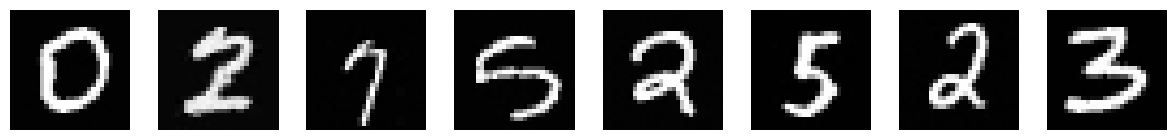

In [24]:
for images, _ in train_loader:
    # Move the images to the GPU
    images = images.to(device)
    # Add Gaussian noise
    # noises = torch.normal(mean, std_dev, size=images.shape).to(device)
    # noisy_images = images + noises
    # outputs = vit_model(images)
    samples = vit_model((torch.maximum(test_samples[:16,:,:], noise)).to(device)).cpu()

    with torch.no_grad():
        noise = torch.ones((1, 1, 28, 28)) * 1
        print_images(images[:8,:,:].cpu())
        noise[:, :, 8:20, 8:20] = -1
        print_images(torch.minimum(images[:8].cpu(), noise))
        outputs = vit_model(torch.minimum(images[:8], noise.to(device))).cpu()
        for i in range(10):
            outputs = vit_model(outputs[:8].to(device)).cpu()
    print_images(outputs[:8].cpu())
    
    # loss = criterion(outputs, images)

* 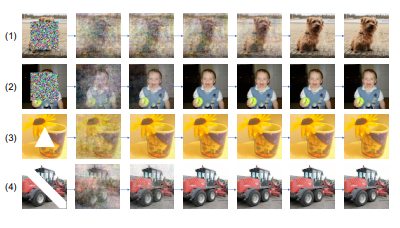

In [55]:
test_samples[:16,:,:].max()

tensor(1.)

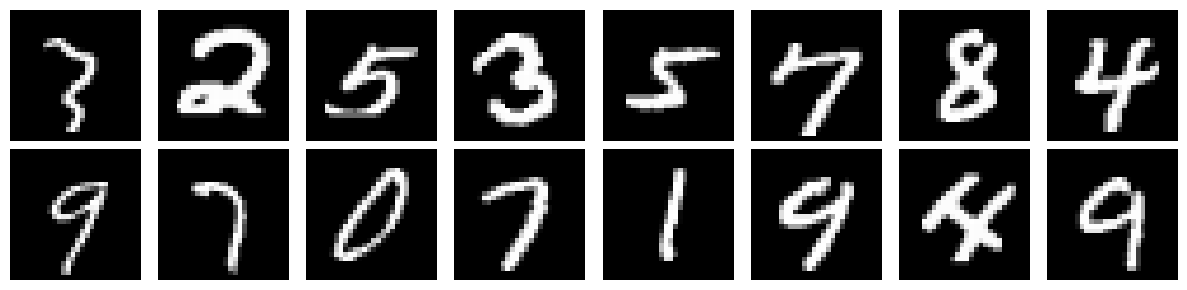

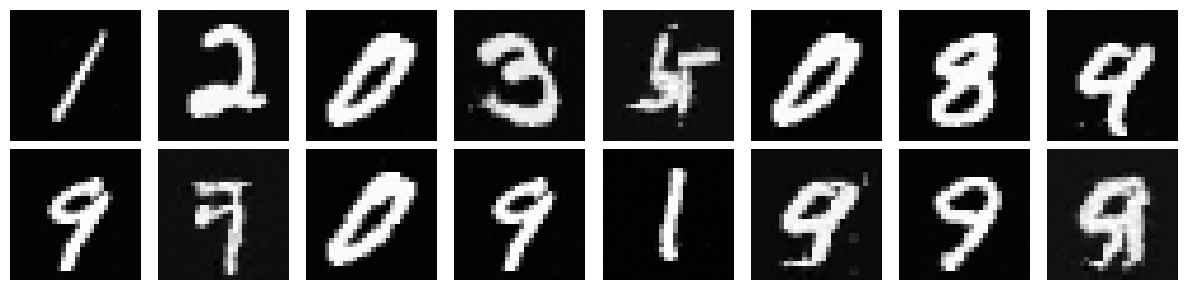

In [56]:
print_images(test_samples[:16,:,:])
with torch.no_grad():
    noise = torch.zeros((1, 28, 28))
    noise[:, 10:15, 10:15] = 1
    samples = vit_model(test_samples[:16,:,:].to(device)).cpu()
    for i in range(500):
        samples = vit_model(samples.to(device)).cpu()
    print_images(samples)

In [ ]:
print_images(test_samples[:,:,:])
with torch.no_grad():
    samples = vit_model(test_samples[:,:,:].to(device)).cpu()
    for i in range(100):
        samples = vit_model(samples.to(device)).cpu()
    print_images(samples)

In [ ]:
sample = sample_images[-1:,:,:]
print_images(sample)
for i in range(400):
    with torch.no_grad():
        sample = vit_model(sample.to(device)).cpu()
    print_images(sample)

In [ ]:
vit_model(sample_images[0:,:,:].to(device)).cpu()